In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-JPY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

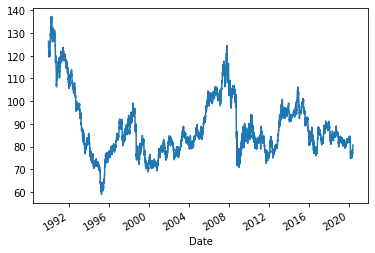

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot()

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** After large crash between 1992 and 1996, there is no clear trend between 1997 and 2020 as the price just fluctuates.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
price_noise, price_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_filter = cad_jpy_df["Price"].to_frame()
cad_jpy_filter["noise"] = price_noise
cad_jpy_filter["trend"] = price_trend
cad_jpy_filter.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

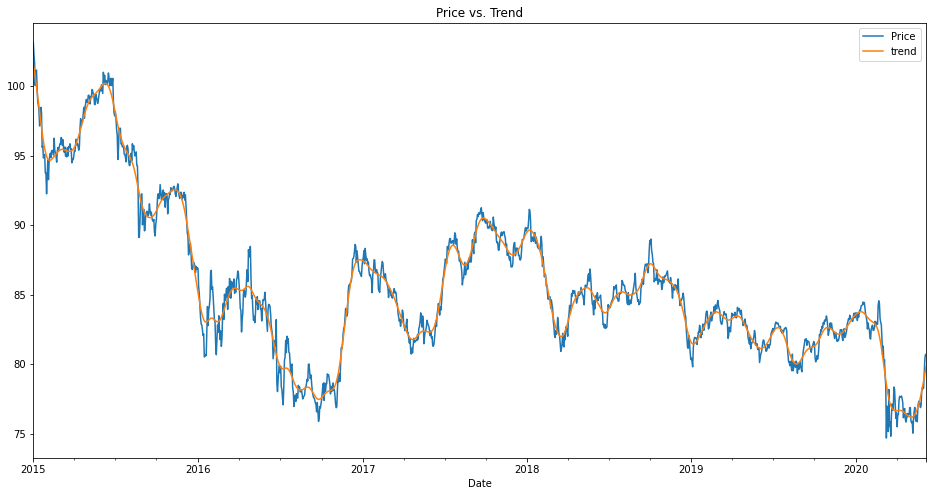

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_filter[cad_jpy_filter.index >= '2015-01-01'][["Price", "trend"]].plot(title="Price vs. Trend", figsize=(16, 8), xlabel="Date")

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Between 2015 and 2020, there is a downward trend as the price reaches a new low in 2020.

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

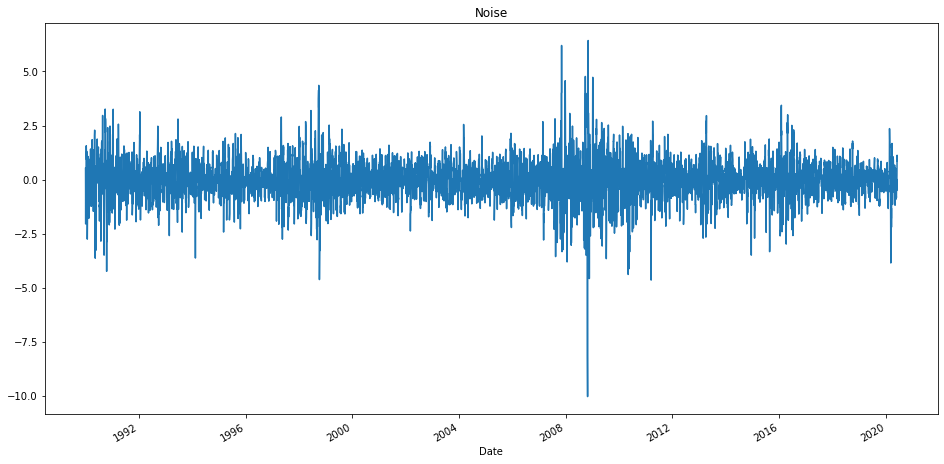

In [8]:
# Plot the Settle Noise
cad_jpy_filter["noise"].plot(title="Noise", xlabel="Date", figsize=(16, 8))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
#import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARMA model using statsmodels (use order=(2, 1)), which is ARIMA order(2,0,1)
model = ARIMA(returns.values, order=(2,0,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -9752.310
Date:                Sat, 06 Aug 2022   AIC                          19514.620
Time:                        21:26:53   BIC                          19549.511
Sample:                             0   HQIC                         19526.568
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.237      0.813      -0.021       0.016
ar.L1         -0.0152      3.499     -0.004      0.997      -6.873       6.843
ar.L2         -0.0018      0.107     -0.017      0.987      -0.212       0.209
ma.L1         -0.0153      3.499     -0.004      0.997      -6.874       6.844
sigma2         0.6855      0.006    122.678      0.000       0.675       0.696
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11578.41
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

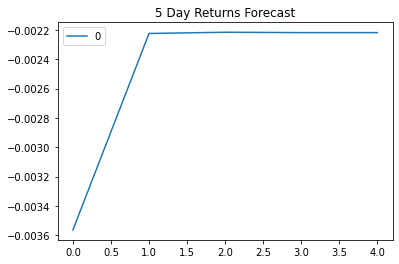

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** The p-values are all mostly very high, suggesting a very poor fit.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [13]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(returns.values, order=(5,1,1))

# Fit the model
results = model.fit()

In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9754.288
Date:                Sat, 06 Aug 2022   AIC                          19522.576
Time:                        21:27:01   BIC                          19571.422
Sample:                             0   HQIC                         19539.302
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0303      0.007     -4.365      0.000      -0.044      -0.017
ar.L2         -0.0025      0.007     -0.370      0.712      -0.016       0.011
ar.L3         -0.0101      0.008     -1.268      0.205      -0.026       0.006
ar.L4          0.0016      0.007      0.228      0.820      -0.012       0.015
ar.L5         -0.0187      0.007     -2.711      0.007      -0.032      -0.005
ma.L1         -1.0000      0.009   -111.206      0.000      -1.018      -0.982
sigma2         0.6852      0.009     76.706      0.000       0.668       0.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11614.37
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

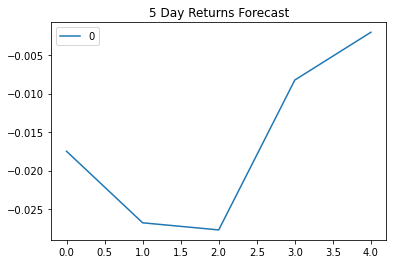

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)).plot(title="5 Day Returns Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The model forecasts that the Japanese Yen goes down in the near term.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
!pip install arch
from arch import arch_model

In [17]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 306850859.3384427
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838861417698
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11771.663036006626
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.31072801688
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.369930732108
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.112105819691
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027322298947
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.022077988246
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021067661106
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020797453917
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764880363
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.020764882265
Optimization terminated successfully    (Exit mode 0)
         

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sat, Aug 06 2022   Df Residuals:                     7928
Time:                        21:27:04   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

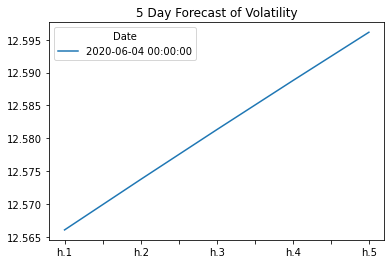

In [23]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Volatility will increase in the near term.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

Based on the analysis, June 2020 would not be a good time to buy Japanese Yen.

2. Is the risk of the yen expected to increase or decrease?

Volatility of Japanese Yen is expected to increase.

3. Based on the model evaluation, would you feel confident in using these models for trading?

The predictions for volatility are reasonably reliable, but the predictions for prices are not.